# CS72 Final Project: Zipf's Law and Word Embeddings

### Harrison Stropkay (harrison.f.stropkay.25@dartmouth.edu)

### Professor Rolando Coto-Solano 

In [1]:
import pandas as pd
import os
import chardet
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, pearsonr
import gensim
from xml.etree import ElementTree as ET
from nltk.tokenize.stanford_segmenter import StanfordSegmenter
import multiprocessing
from tqdm import tqdm
import fasttext.util
import gensim.downloader as gensim_api

In [2]:
sns.set_theme(style="whitegrid")

# Data collation

## Wikipedia word frequencies

Data credit: https://github.com/IlyaSemenov/wikipedia-word-frequency/

In [3]:
languages_data = {
    "afrikaans": {
        "code": "af",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/afwiki-2024-02-20.txt",
    },
    "arabic": {
        "code": "ar",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/arwiki-2022-08-29.txt",
    },
    "cebuano": {
        "code": "ceb",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/cebwiki-2024-02-20.txt",
    },
    "german": {
        "code": "de",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/dewiki-2022-08-29.txt",
    },
    "english": {
        "code": "en",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/enwiki-2023-04-13.txt",
    },
    "spanish": {
        "code": "es",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/eswiki-2022-08-29.txt",
    },
    "french": {
        "code": "fr",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/frwiki-2022-08-29.txt",
    },
    "italian": {
        "code": "it",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/itwiki-2022-08-30.txt",
    },
    "japanese": {
        "code": "ja",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/jawiki-2022-08-29.txt",
    },
    "dutch": {
        "code": "nl",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/nlwiki-2022-08-29.txt",
    },
    "polish": {
        "code": "pl",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/plwiki-2022-08-29.txt",
    },
    "portuguese": {
        "code": "pt",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/ptwiki-2022-08-29.txt",
    },
    "russian": {
        "code": "ru",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/ruwiki-2022-08-29.txt",
    },
    "swedish": {
        "code": "sv",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/svwiki-2022-08-30.txt",
    },
    "swahili": {
        "code": "sw",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/swwiki-2024-02-20.txt",
    },
    "ukrainian": {
        "code": "uk",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/ukwiki-2022-08-30.txt",
    },
    "vietnamese": {
        "code": "vi",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/viwiki-2022-08-30.txt",
    },
    "chinese": {
        "code": "zh",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/zhwiki-2022-08-30.txt",
    },
}

## Download word frequencies and fastText models for varying languages

In [4]:
model_dir = "data/models"

for language, data in languages_data.items():
    if os.path.exists(f"data/counts/{language}.csv"):
        print(f"{language} data already downloaded")
    else:
        print(f"Downloading {language} data")
        df = pd.read_csv(data["url"], sep=" ", header=None, names=["word", "count"])
        df.to_csv(f"data/counts/{language}.csv", index=False)

    if os.path.exists(f"data/models/cc.{data['code']}.300.bin"):
        print(f"{language} model already downloaded")
    else:
        print(f"Downloading {language} model")
        # change directory to the model directory
        os.chdir(model_dir)
        fasttext.util.download_model(data["code"], if_exists="ignore")
        # change directory back to the original directory
        os.chdir("../..")

afrikaans data already downloaded
afrikaans model already downloaded
arabic data already downloaded
arabic model already downloaded
cebuano data already downloaded
cebuano model already downloaded
german data already downloaded
german model already downloaded
english data already downloaded
english model already downloaded
spanish data already downloaded
spanish model already downloaded
french data already downloaded
french model already downloaded
italian data already downloaded
italian model already downloaded
japanese data already downloaded
japanese model already downloaded
dutch data already downloaded
dutch model already downloaded
polish data already downloaded
polish model already downloaded
portuguese data already downloaded
portuguese model already downloaded
russian data already downloaded
russian model already downloaded
swedish data already downloaded
swedish model already downloaded
swahili data already downloaded
swahili model already downloaded
ukrainian data already do

# Combine embeddings and word frequencies

### Gensim embeddings

To compare Word2Vec and GloVe embeddings with fastText while holding the language constant.

In [5]:
gensim_dict = {
    "word2vec": "word2vec-google-news-300",
    "glove": "glove-wiki-gigaword-300",
    "fasttext": "fasttext-wiki-news-subwords-300",
}

df_english_counts = pd.read_csv("data/counts/english.csv")

for model_name, model_id in gensim_dict.items():
    output_name = f"data/final/english-{model_name}.csv"
    if os.path.exists(output_name):
        print(f"{model_name} already collated")
        continue

    print(f"Downloading {model_name} model")
    model = gensim_api.load(model_id)

    df_magnitude = []
    for word in model.key_to_index:
        embedding = model.get_vector(word)
        magnitude = np.linalg.norm(embedding)
        df_magnitude.append({"word": word, "magnitude": magnitude})
    df_magnitude = pd.DataFrame(df_magnitude)

    df_merged = pd.merge(df_english_counts, df_magnitude, on="word", how="inner")
    df_merged["frequency"] = df_merged["count"] / df_merged["count"].sum()
    df_merged["frequency_rank"] = df_merged["frequency"].rank(ascending=False)
    df_merged["magnitude_rank"] = df_merged["magnitude"].rank(ascending=False)

    # Keep only the top 100,000 by frequency rank
    df_merged = df_merged.sort_values("frequency_rank").head(100000)

    df_merged.to_csv(output_name, index=False)

word2vec already collated
glove already collated


### fastText embeddings 

To compare word embeddings across languages while holding the emebedding model constant. 

In [6]:
for language, data in languages_data.items():
    if os.path.exists(f"data/final/{language}.csv"):
        print(f"{language} final dataset already generated")
        continue

    print(f"Generating {language} final dataset")
    df_counts = pd.read_csv(f"data/counts/{language}.csv")

    ft = fasttext.load_model(f"data/models/cc.{data['code']}.300.bin")

    df_magnitudes = []
    for word in df_counts["word"]:
        try:
            vec = ft.get_word_vector(word)
            magnitude = np.linalg.norm(vec)
            df_magnitudes.append({"word": word, "magnitude": magnitude})
        except:
            pass
    df_magnitudes = pd.DataFrame(df_magnitudes)
    df_merged = pd.merge(df_counts, df_magnitudes, on="word")

    df_merged["frequency"] = df_merged["count"] / df_merged["count"].sum()
    df_merged["frequency_rank"] = df_merged["frequency"].rank(ascending=False)
    df_merged["magnitude_rank"] = df_merged["magnitude"].rank(ascending=False)

    # Only keep the top 100,000 words by frequency rank
    df_merged = df_merged.sort_values("frequency_rank").head(100000)
    df_merged.to_csv(f"data/final/{language}.csv", index=False)

afrikaans final dataset already generated
arabic final dataset already generated
cebuano final dataset already generated
german final dataset already generated
english final dataset already generated
spanish final dataset already generated
french final dataset already generated
italian final dataset already generated
japanese final dataset already generated
dutch final dataset already generated
polish final dataset already generated
portuguese final dataset already generated
russian final dataset already generated
swedish final dataset already generated
swahili final dataset already generated
ukrainian final dataset already generated
vietnamese final dataset already generated
chinese final dataset already generated


# Experiments

## Confirming Zipf's Law

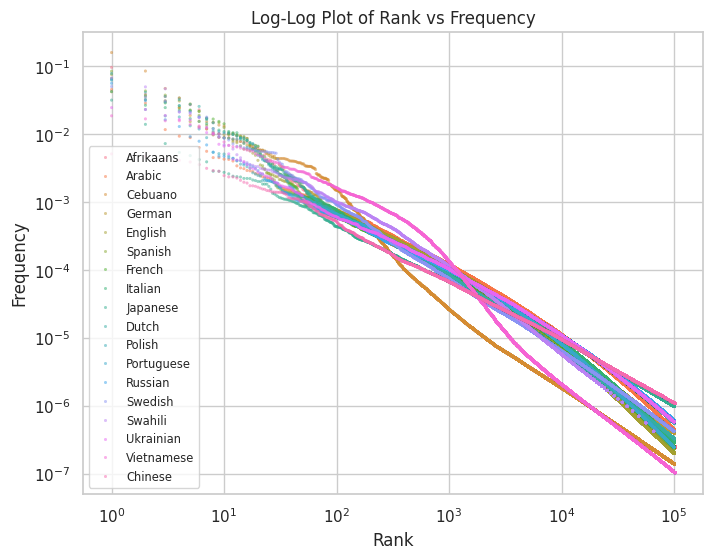

In [7]:
# Define the new power law function with only parameter c
def power_law(x, c):
    return c / x


# Function to load data, fit the curve, and return the necessary data
def process_language_data(language):
    df = pd.read_csv(f"data/final/{language}.csv")
    df["rank"] = df["frequency_rank"]
    df["frequency"] = df["frequency"]
    df["language"] = language.capitalize()

    x_data = df["rank"].values
    y_data = df["frequency"].values

    # Fit the curve with the new function
    params, _ = curve_fit(power_law, x_data, y_data)
    c_best_fit = params[0]

    df["c_best_fit"] = c_best_fit

    return df


# Concatenate all dataframes
df_all = pd.concat(
    [process_language_data(language) for language in languages_data.keys()],
    ignore_index=True,
)

for t in [False]:
    # Plot the data and the best fit curves using seaborn
    plt.figure(figsize=(8, 6))

    # Scatter plot
    sns.scatterplot(
        data=df_all,
        x="rank",
        y="frequency",
        hue="language",
        s=4,
        edgecolor=None,
        alpha=0.5,
    )

    if t:
        # Plot the best fit curves
        for lang, group_df in df_all.groupby("language"):
            x_data = group_df["rank"].values
            c_best_fit = group_df["c_best_fit"].values[0]
            plt.plot(
                x_data,
                power_law(x_data, c_best_fit),
                label=f"{lang} best fit: f(x) = {c_best_fit:.3f}/x",
            )
    title = (
        "Log-Log Plot of Rank vs Frequency with Best Fit Curves"
        if t
        else "Log-Log Plot of Rank vs Frequency"
    )

    plt.ylabel("Frequency")
    plt.xlabel("Rank")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.legend(loc="lower left", fontsize="x-small")
    plt.show()

## Model experiments

In [8]:
model_data = {
    "word2vec": "english-word2vec",
    "glove": "english-glove",
    "fasttext": "english-fasttext",
}

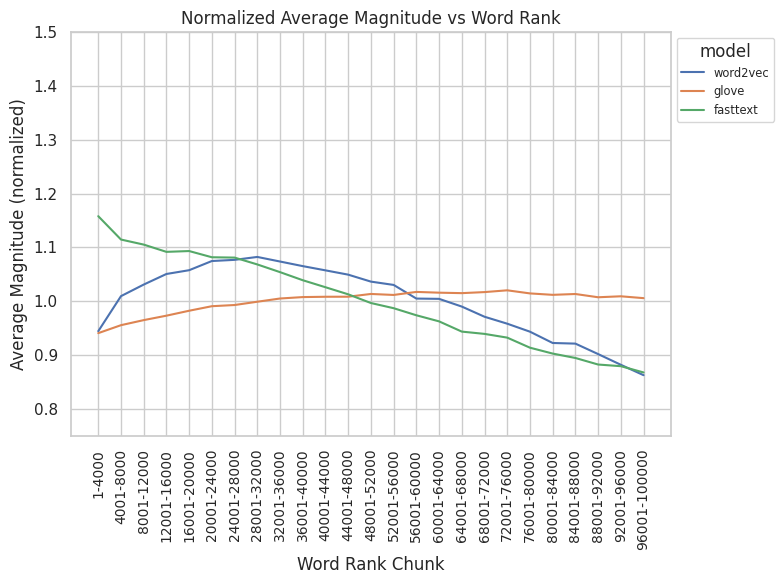

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


num_words_per_chunk = 4000
num_chunks = 25

avg_magnitudes = []
for model, modelname in model_data.items():
    # Read the data for the model
    df = pd.read_csv(f"data/final/{modelname}.csv")
    df = df.sort_values("frequency_rank")

    # Normalize magnitudes so the average magnitude of the dataset is 1
    avg_magnitude_dataset = df["magnitude"].mean()
    df["magnitude"] = df["magnitude"] / avg_magnitude_dataset

    # Calculate average magnitude for each chunk
    for i in range(num_chunks):
        chunk_start = i * num_words_per_chunk
        chunk_end = chunk_start + num_words_per_chunk
        chunk = df.iloc[chunk_start:chunk_end]
        avg_magnitude = chunk["magnitude"].mean()

        avg_magnitudes.append(
            {
                "Word Rank Chunk": f"{chunk_start + 1}-{chunk_end}",
                "Average Magnitude": avg_magnitude,
                "model": model,
            }
        )

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=pd.DataFrame(avg_magnitudes),
    x="Word Rank Chunk",
    y="Average Magnitude",
    hue="model",
    # make the x-axis labels more readable, font size smaller
)
plt.xticks(rotation=90, fontsize="small")
plt.xlabel("Word Rank Chunk")
plt.ylim(0.75, 1.5)
plt.ylabel("Average Magnitude (normalized)")
plt.title(f"Normalized Average Magnitude vs Word Rank")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="x-small", title="model")
plt.grid(True)
plt.tight_layout()
plt.show()

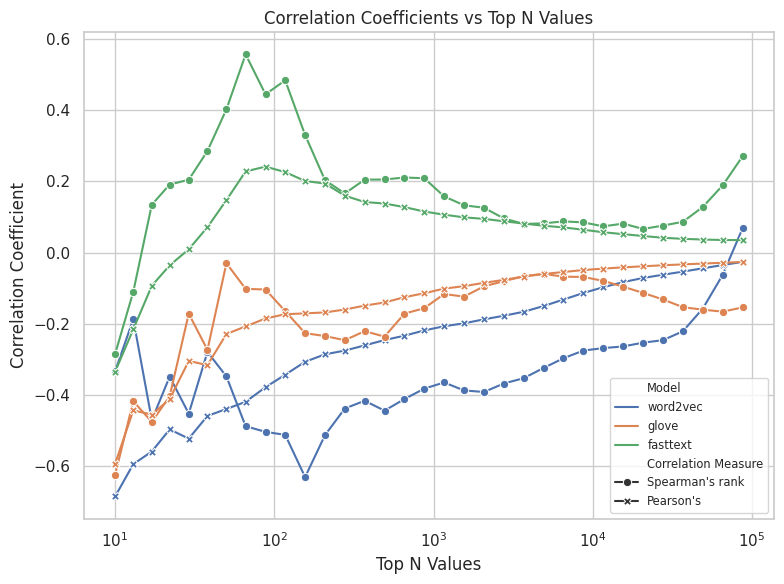

In [10]:
start_value = 10
ratio = 10 ** (1 / 8)
cap = 100000
top_n_values = []
while start_value <= cap:
    top_n_values.append(start_value)
    start_value = int(start_value * ratio)

correlations = []
for model, modelname in model_data.items():
    for top_n in top_n_values:
        df_model = pd.read_csv(f"data/final/{modelname}.csv")
        df_model = df_model.head(top_n)

        # Calculate the correlation coefficients
        spearman_corr, _ = spearmanr(
            df_model["magnitude_rank"], df_model["frequency_rank"]
        )
        pearson_corr, _ = pearsonr(df_model["magnitude"], df_model["frequency"])

        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": spearman_corr,
                "Correlation Measure": "Spearman's rank",
                "Model": model,
            }
        )
        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": pearson_corr,
                "Correlation Measure": "Pearson's",
                "Model": model,
            }
        )

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=pd.DataFrame(correlations),
    x="Top N Values",
    y="Correlation Coefficient",
    hue="Model",
    style="Correlation Measure",
    dashes=False,
    markers=True,
)
plt.xscale("log")
plt.xlabel("Top N Values")
plt.ylabel("Correlation Coefficient")
plt.title(f"Correlation Coefficients vs Top N Values")
plt.legend(loc="lower right", fontsize="x-small")
plt.grid(True)
plt.tight_layout()
plt.show()

## Language experiments

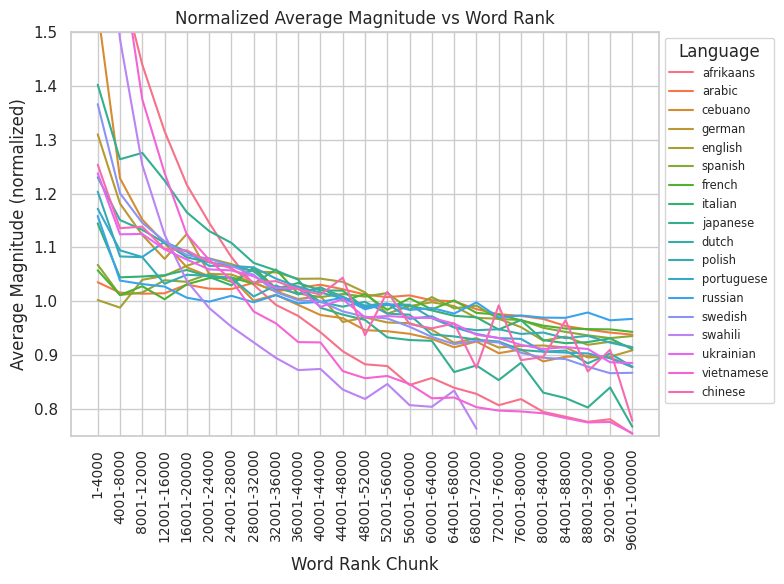

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


num_words_per_chunk = 4000
num_chunks = 25

avg_magnitudes = []
for language in languages_data.keys():
    # Read the data for the model
    df = pd.read_csv(f"data/final/{language}.csv")
    df = df.sort_values("frequency_rank")

    # Normalize magnitudes so the average magnitude of the dataset is 1
    avg_magnitude_dataset = df["magnitude"].mean()
    df["magnitude"] = df["magnitude"] / avg_magnitude_dataset

    # Calculate average magnitude for each chunk
    for i in range(num_chunks):
        chunk_start = i * num_words_per_chunk
        chunk_end = chunk_start + num_words_per_chunk
        chunk = df.iloc[chunk_start:chunk_end]
        avg_magnitude = chunk["magnitude"].mean()

        avg_magnitudes.append(
            {
                "Word Rank Chunk": f"{chunk_start + 1}-{chunk_end}",
                "Average Magnitude": avg_magnitude,
                "Language": language,
            }
        )

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=pd.DataFrame(avg_magnitudes),
    x="Word Rank Chunk",
    y="Average Magnitude",
    hue="Language",
    # make the x-axis labels more readable, font size smaller
)
plt.xticks(rotation=90, fontsize="small")
plt.xlabel("Word Rank Chunk")
plt.ylim(0.75, 1.5)
plt.ylabel("Average Magnitude (normalized)")
plt.title(f"Normalized Average Magnitude vs Word Rank")
plt.legend(
    loc="upper left", bbox_to_anchor=(1, 1), fontsize="x-small", title="Language"
)
plt.grid(True)
plt.tight_layout()
plt.show()

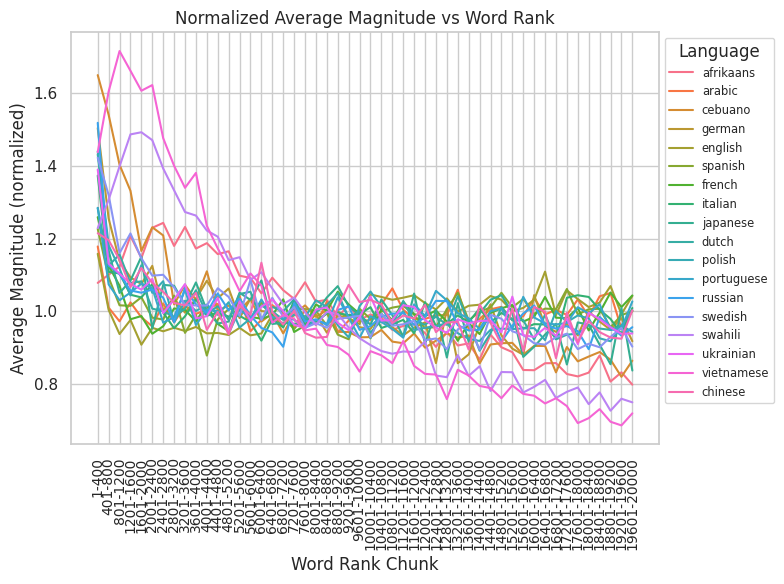

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


num_words_per_chunk = 400
num_chunks = 50

avg_magnitudes = []
for language in languages_data.keys():
    # Read the data for the model
    df = pd.read_csv(f"data/final/{language}.csv")
    df = df.sort_values("frequency_rank")
    df = df.head(num_words_per_chunk * num_chunks)

    # Normalize magnitudes so the average magnitude of the dataset is 1
    avg_magnitude_dataset = df["magnitude"].mean()
    df["magnitude"] = df["magnitude"] / avg_magnitude_dataset

    # Calculate average magnitude for each chunk
    for i in range(num_chunks):
        chunk_start = i * num_words_per_chunk
        chunk_end = chunk_start + num_words_per_chunk
        chunk = df.iloc[chunk_start:chunk_end]
        avg_magnitude = chunk["magnitude"].mean()

        avg_magnitudes.append(
            {
                "Word Rank Chunk": f"{chunk_start + 1}-{chunk_end}",
                "Average Magnitude": avg_magnitude,
                "Language": language,
            }
        )

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=pd.DataFrame(avg_magnitudes),
    x="Word Rank Chunk",
    y="Average Magnitude",
    hue="Language",
    # make the x-axis labels more readable, font size smaller
)
plt.xticks(rotation=90, fontsize="small")
plt.xlabel("Word Rank Chunk")
plt.ylabel("Average Magnitude (normalized)")
plt.title(f"Normalized Average Magnitude vs Word Rank")
plt.legend(
    loc="upper left", bbox_to_anchor=(1, 1), fontsize="x-small", title="Language"
)
plt.grid(True)
plt.tight_layout()
plt.show()

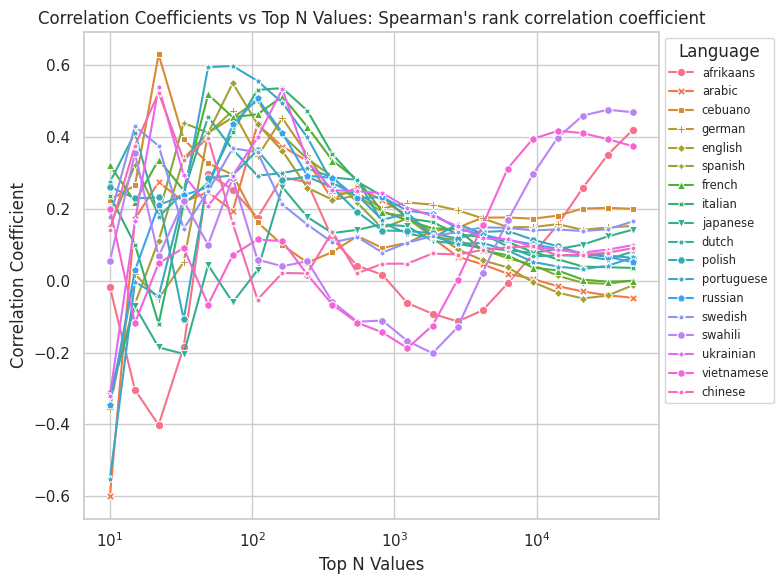

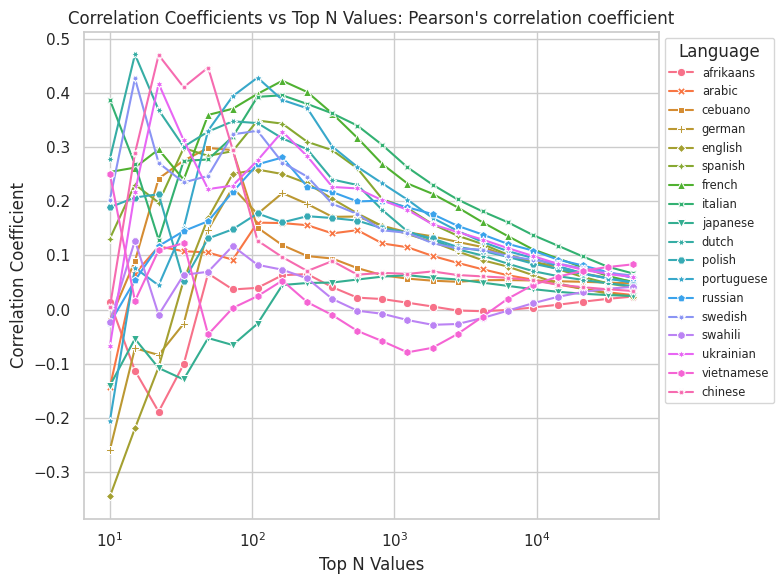

In [13]:
start_value = 10
ratio = 1.5
cap = 50000
top_n_values = []
while start_value <= cap:
    top_n_values.append(start_value)
    start_value = int(start_value * ratio)

correlations = []
for language in languages_data.keys():
    for top_n in top_n_values:
        df_model = pd.read_csv(f"data/final/{language}.csv")
        df_model = df_model.head(top_n)

        # Calculate the correlation coefficients
        spearman_corr, _ = spearmanr(
            df_model["magnitude_rank"], df_model["frequency_rank"]
        )
        pearson_corr, _ = pearsonr(df_model["magnitude"], df_model["frequency"])

        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": spearman_corr,
                "Correlation Measure": "Spearman's rank correlation coefficient",
                "Language": language,
            }
        )
        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": pearson_corr,
                "Correlation Measure": "Pearson's correlation coefficient",
                "Language": language,
            }
        )

for correlation_measure in [
    "Spearman's rank correlation coefficient",
    "Pearson's correlation coefficient",
]:
    df = pd.DataFrame(correlations)
    df = df[df["Correlation Measure"] == correlation_measure]

    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=df,
        x="Top N Values",
        y="Correlation Coefficient",
        hue="Language",
        style="Language",
        dashes=False,
        markers=True,
    )
    plt.xscale("log")
    plt.xlabel("Top N Values")
    plt.ylabel("Correlation Coefficient")
    plt.title(f"Correlation Coefficients vs Top N Values: {correlation_measure}")
    plt.legend(
        loc="upper left", bbox_to_anchor=(1, 1), fontsize="x-small", title="Language"
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()